In [38]:
from fastai.vision.all import *
from tqdm.notebook import tqdm

In [39]:
emb_size = 128  # 학습용 임베딩 차원
output_classes = 10
batch_size = 1
margin_m = 0.3
scale_s = 30.0


MNIST 분류기의 마지막 layer를 먼저 정의해보자. input size는 임베딩 크기인 3, output size는 class 수 10이 될 것이다. 마지막 layer의 

In [40]:
classifier = nn.Linear(emb_size, output_classes, bias=False)
W = classifier.weight.T
print(W.shape)

torch.Size([128, 10])



batch size의 임베딩 x를 정의하고 이를 classifier에 넣은 결과는 x와 classifier의 가중치 W를 행렬곱한 것과 결과가 같다.

In [41]:
x = torch.randn((batch_size, emb_size))
y1 = classifier(x)
y2 = x@W

y1.shape, (y1==y2).all()

(torch.Size([1, 10]), tensor(True))

x와 W를 모두 정규화하면 둘의 행렬곱 값은 cosine 유사도와 같아진다. 아래 코드를 통해 행렬곱과 유사도를 구해보면 같은 값을 출력하는 것을 확인할 수 있다. W의 4번째 컬럼을 이용해 확인했다.

In [42]:
x = F.normalize(x)
W = F.normalize(W, dim = 0)

outputs = x@W
sim04 = F.cosine_similarity(x[0], W[:, 4], dim = 0)
sim04, outputs[0][4]

(tensor(0.0810, grad_fn=<SumBackward1>),
 tensor(0.0810, grad_fn=<SelectBackward0>))

arccos 함수(cos의 역함수)를 통해 각도를 구해보자.

In [43]:
angle_output = outputs.arccos()
angle_output[0]


tensor([1.6398, 1.5757, 1.6034, 1.6068, 1.4897, 1.5124, 1.4847, 1.4856, 1.5439,
        1.6609], grad_fn=<SelectBackward0>)

In [44]:
angle_output[0].rad2deg()

tensor([93.9543, 90.2803, 91.8708, 92.0619, 85.3531, 86.6551, 85.0680, 85.1185,
        88.4618, 95.1612], grad_fn=<Rad2DegBackward0>)

각도가 작아져 cosine 값이 1에 가까워질 수록 cross entropy loss는 커진다.

 

ArcFace는 다음과 같이 여러 단계로 수행된다.

1. 임베딩과 가중치를 정규화한다.
2. 내적을 계산한다.
3. arccos 함수로 각도를 계산한다.
4. ground truth label에 해당하는 각도에 마진 m을 더해준다.
5. 각도를 다시 cosine 값으로 되돌린다.
6. 새로운 cosine 값에 대해 cross entropy loss를 계산한다.

In [45]:
class ArcFaceClassifier(nn.Module):
    def __init__(self, emb_size, output_classes):
        super().__init__()
        self.W = nn.Parameter(torch.empty(emb_size, output_classes))
        nn.init.kaiming_uniform_(self.W)
    
    def forward(self, x):
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim = 0)
        return x_norm @ W_norm

def add_arcface_margin(cosine, targ, m=margin_m, s=scale_s):
    cosine = cosine.clamp(-1+1e-7, 1-1e-7)
    theta = cosine.acos()
    logits = cosine.clone()
    idx = torch.arange(len(targ), device=targ.device)
    logits[idx, targ] = torch.cos(theta[idx, targ] + m)
    logits = logits * s
    return logits

def arcface_loss(cosine, targ, m=margin_m, s=scale_s):
    # ArcFace: 타깃 로짓에만 margin을 적용하고 전체를 s로 스케일
    logits = add_arcface_margin(cosine, targ, m=m, s=s)
    return F.cross_entropy(logits, targ)


아주 간단한 형태의 convolutional network를 구현한다. forward 함수는 classifier까지 거치고, embedding은 classifier를 거치기 전이므로 각각을 따로 구현한다.

In [46]:
# 학습 후 128차원 임베딩을 3차원으로 투영해 시각화하는 예시
from sklearn.decomposition import PCA

def project_to_3d(encoder, loader, device='cpu'):
    encoder.eval()
    feats, labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            feats.append(encoder(xb).cpu())
            labels.append(yb.cpu())
    feats = torch.cat(feats).numpy()
    labels = torch.cat(labels).numpy()
    feats3d = PCA(n_components=3).fit_transform(feats)
    return feats3d, labels


MNIST 데이터를 불러오고 DataLoader를 만든 뒤 학습에 사용한다.

In [47]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root='data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.71MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 148kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.83MB/s]


간단한 encoder와 ArcFace head를 정의하고 학습 루프를 실행한다.

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class SimpleEncoder(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, emb_size),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.head(x)
        return x

encoder = SimpleEncoder(emb_size).to(device)
arcface_head = ArcFaceClassifier(emb_size, output_classes).to(device)

params = list(encoder.parameters()) + list(arcface_head.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)
epochs = 3

for epoch in range(epochs):
    encoder.train()
    arcface_head.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        feats = encoder(xb)
        cosine = arcface_head(feats)
        loss = arcface_loss(cosine, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        with torch.no_grad():
            logits = add_arcface_margin(cosine, yb)
            pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += xb.size(0)
    print(f'Epoch {epoch+1}: loss={running_loss/total:.4f}, acc={correct/total:.4f}')


Epoch 1/3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: loss=1.1927, acc=0.8633


Epoch 2/3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: loss=0.2413, acc=0.9692


Epoch 3/3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: loss=0.1547, acc=0.9795


검증 정확도를 계산하고, 학습된 임베딩을 3차원으로 줄여 시각화한다.

Test acc: 0.9772


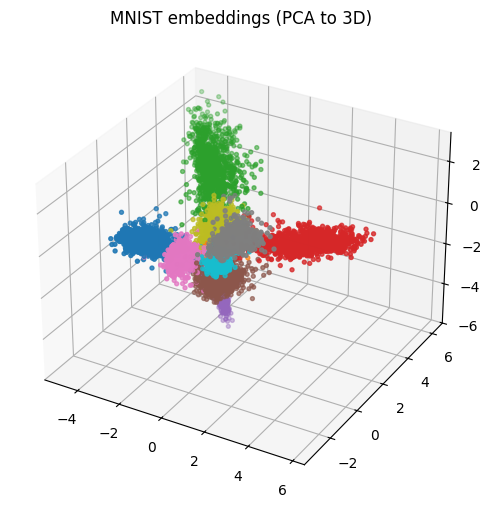

In [49]:
encoder.eval()
arcface_head.eval()
test_correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        feats = encoder(xb)
        cosine = arcface_head(feats)
        logits = add_arcface_margin(cosine, yb)
        pred = logits.argmax(dim=1)
        test_correct += (pred == yb).sum().item()
        total += xb.size(0)
print(f'Test acc: {test_correct/total:.4f}')

# 3D PCA 시각화 예시 (시간 절약을 위해 필요시 실행)
feats3d, labels = project_to_3d(encoder, test_loader, device=device)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(feats3d[:, 0], feats3d[:, 1], feats3d[:, 2], c=labels, cmap='tab10', s=3)
ax.set_title('MNIST embeddings (PCA to 3D)')
plt.show()


Softmax baseline: 같은 인코더 구조로 margin 없이 학습한 결과를 비교한다.

In [ ]:
# Softmax baseline 학습
softmax_encoder = SimpleEncoder(emb_size).to(device)
softmax_cls = nn.Linear(emb_size, output_classes).to(device)

params = list(softmax_encoder.parameters()) + list(softmax_cls.parameters())
opt_sm = torch.optim.Adam(params, lr=1e-3)
epochs_sm = 3

for epoch in range(epochs_sm):
    softmax_encoder.train()
    softmax_cls.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in tqdm(train_loader, desc=f'Softmax Epoch {epoch+1}/{epochs_sm}'):
        xb, yb = xb.to(device), yb.to(device)
        opt_sm.zero_grad()
        feats = softmax_encoder(xb)
        logits = softmax_cls(feats)
        loss = F.cross_entropy(logits, yb)
        loss.backward()
        opt_sm.step()

        running_loss += loss.item() * xb.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += xb.size(0)
    print(f'Softmax Epoch {epoch+1}: loss={running_loss/total:.4f}, acc={correct/total:.4f}')


In [ ]:
# Softmax baseline 검증 및 3D 투영(옵션)
softmax_encoder.eval()
softmax_cls.eval()
test_correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        feats = softmax_encoder(xb)
        logits = softmax_cls(feats)
        pred = logits.argmax(dim=1)
        test_correct += (pred == yb).sum().item()
        total += xb.size(0)
print(f'Softmax Test acc: {test_correct/total:.4f}')

# PCA 3D 투영 비교 예시 (필요 시 실행)
feats3d_sm, labels_sm = project_to_3d(softmax_encoder, test_loader, device=device)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feats3d_sm[:, 0], feats3d_sm[:, 1], feats3d_sm[:, 2], c=labels_sm, cmap='tab10', s=8)
ax.set_title('Softmax embeddings (PCA to 3D)')
plt.show()
